In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented")

print("Path to dataset files:", path)

100%|██████████| 169M/169M [00:02<00:00, 60.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions/2


In [2]:
import os
from glob import glob

os.environ['WANDB_MODE'] = 'disabled'

for dirname, _, _ in os.walk('/root/.cache/kagglehub/datasets'):
    print(dirname)

/root/.cache/kagglehub/datasets
/root/.cache/kagglehub/datasets/subhajeetdas
/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented
/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions
/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions/2
/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions/2/Augmented IQ-OTHNCCD lung cancer dataset
/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions/2/Augmented IQ-OTHNCCD lung cancer dataset/Malignant cases
/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions/2/Augmented IQ-OTHNCCD lung cancer dataset/Benign cases
/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions/2/Augmented IQ-OTHNCCD lung cancer dataset/Normal cases


In [3]:
#IMPORTAMOS LIBRERIAS
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import datasets, models, Sequential, regularizers
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

PROCESAMIENTO DE IMAGENES PARA VGG16

In [4]:
# Ejemplo de uso ImageDataGenerator para cargar y preprocesamiento de imagenes de un directorio
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Preprocess_input es una funcion para preparar las imagenes para el modelo VGG16
# Resizing: Asegura el tamaño necesario para el modelo VGG16
# Color Channel Adjustment: Convierte imagenes a BGR (Blue,Green and Red)
# Normalization: Ajusta los valores de los pixeles a un rango especifico
generator = datagen.flow_from_directory(
    '/root/.cache/kagglehub/datasets/subhajeetdas/iq-othnccd-lung-cancer-dataset-augmented/versions/2/Augmented IQ-OTHNCCD lung cancer dataset',
    target_size=(226, 226),
    batch_size=32,
    class_mode='categorical', #por las etiquetas en One-hot encoding
    shuffle=False
)

Found 3609 images belonging to 3 classes.


INICIA EL MODELO CON VGG16

In [5]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(226, 226, 3))
# Peso de pre-entreno de 'imagenet' Dataset
# incluse_top = False para evitar la ultima capa de clasificion del model VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Predicciones de caracteristicas
features = vgg.predict(generator, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 2222s 20s/step


In [93]:
# Flatten para el extratrees
X = features.reshape(features.shape[0], -1)

# Obtner las etiquetas del generator
y = generator.classes

In [94]:
num_classes = len(np.unique(y)) #convertimos las etiquetas a numeros, que se obtuvieron en la variable 'generator' que son "3"

Inicia el ExtraTreesCLassifier

In [60]:
#et = ExtraTreesClassifier(n_estimators=100, random_state=42) #Modelo de scikit-learn.org

In [95]:
et = ExtraTreesClassifier(n_estimators=150, criterion='gini')

In [96]:
et.fit(X, y)

ExtraTreesClassifier(n_estimators=150)

In [97]:
print("ET Accuracy:", et.score(X, y))

ET Accuracy: 1.0


Seleccionamos las mejores caracteristicas del modelo

In [98]:
selector = SelectFromModel(et, prefit=True)  # max_features= Se podria ocupar para limitar la seleccion a la cantidad deseada
#prefit es para dar entender que ya esta entrenada la data

In [99]:
X_selected = selector.transform(X)
print("Original feature shape:", X.shape) # Datos creados por VGG16
print("Reduced feature shape:", X_selected.shape) # Datos seleccionados por el ExtraTreesClass
# Recordar que X_selected apesar de a ver sido procesada por Flatten depues del modelo VGG16
# es un 2D array

Original feature shape: (3609, 25088)
Reduced feature shape: (3609, 6879)


Empieza modelo MLP

In [100]:
y_cat = to_categorical(y, num_classes=num_classes)#to_categorical es una tecnica de One-hot encoding
#Ejemplo:
# y  y_cat
# 0 [1,0,0] representa 0, la etiqueta Normal
# 2 [0,0,1] representa 2, la etiqueta Maligna
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X_selected, y_cat, test_size=0.2)

In [101]:
mlp = Sequential([
    Input(shape=(X_selected.shape[1],)), #Capa de entrada con el tamaño del la data seleccionada por ExtraTreesClass
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [102]:
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [103]:
mlp.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │       880,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889,091 (3.39 MB)

 Trainable params: 889,091 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
history = mlp.fit(X_train, y_train_cat, epochs=15, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7323 - loss: 3.6333 - val_accuracy: 0.8920 - val_loss: 0.5113
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9307 - loss: 0.2354 - val_accuracy: 0.9515 - val_loss: 0.1817
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9559 - loss: 0.1372 - val_accuracy: 0.9294 - val_loss: 0.2838
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9646 - loss: 0.1098 - val_accuracy: 0.9571 - val_loss: 0.2259
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9898 - loss: 0.0342 - val_accuracy: 0.9294 - val_loss: 0.3739
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9840 - loss: 0.0496 - val_accuracy: 0.9709 - val_loss: 0.1192
Epoch 7/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9958 - loss: 0.0108 - val_accuracy: 0.9640 - val_loss: 0.1676
Epoch 8/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9723 - v

In [105]:
# Evaluar el modelo
test_loss, test_acc = mlp.evaluate(X_test, y_test_cat, verbose=2)
print(f"\nTest accuracy: %{test_acc*100}")

23/23 - 0s - 8ms/step - accuracy: 0.9778 - loss: 0.1214

Test accuracy: %97.78393507003784


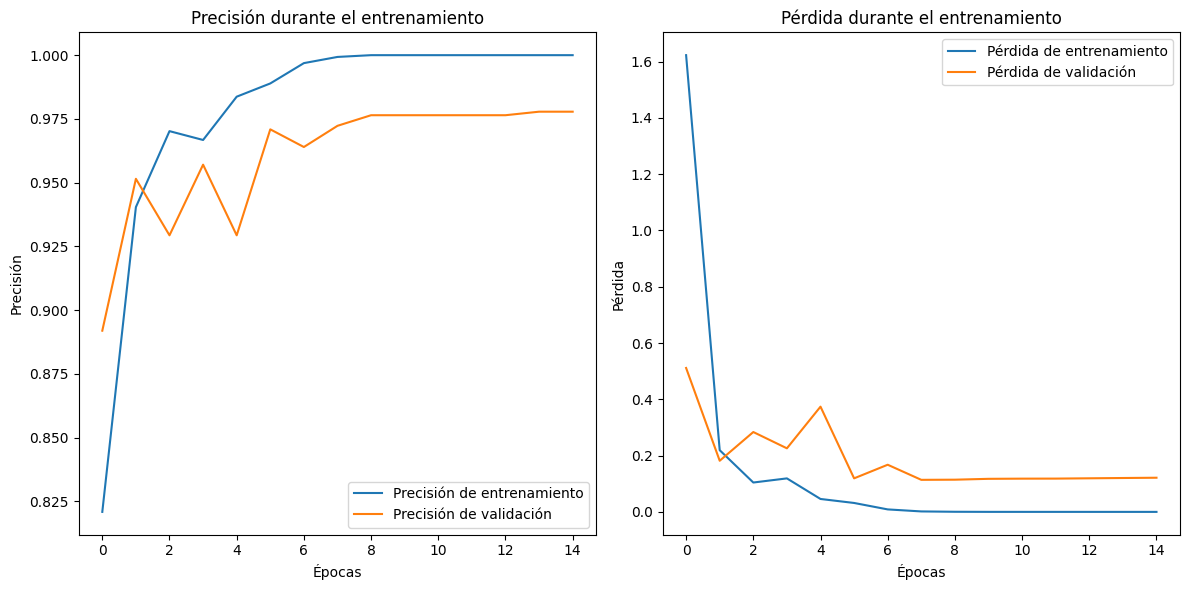

In [106]:
# . Graficar la curva de aprendizaje (pérdida y precisión durante el entrenamiento)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [107]:
# Visualización de las predicciones
# Predecir las clases de las imágenes de test
y_pred = mlp.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(y_pred_classes.shape)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(722,)


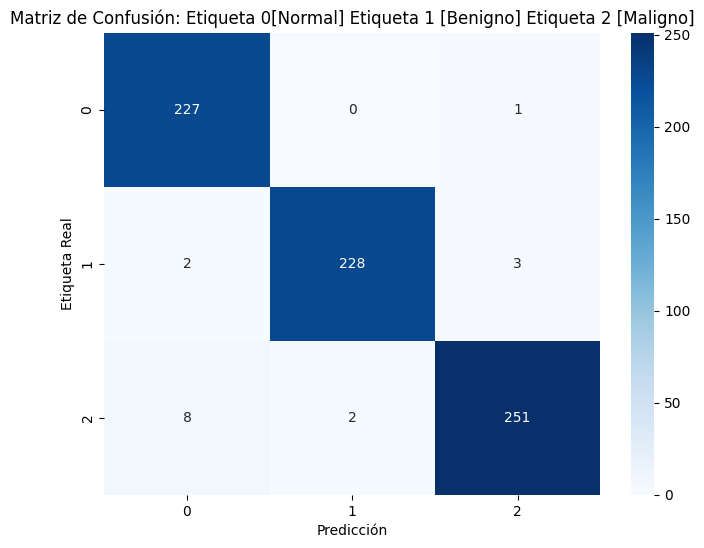

In [108]:
# Convert y_test_cat to multiclass format
y_test_classes = np.argmax(y_test_cat, axis=1)
# Visualizar la matriz de confusión
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(3), yticklabels=np.arange(3))
plt.title('Matriz de Confusión: Etiqueta 0[Normal] Etiqueta 1 [Benigno] Etiqueta 2 [Maligno]')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()